# Segmenting Biological Tissue Images


<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch05_UNet/ec05_1_unet/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [2]:
# !pip install deeplay deeptrack  # Uncomment if using Colab/Kaggle.

This notebook provides you with a complete code example that segments the images of a biological tissue using a U-Net employing early stopping to prevent overfitting.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 5-1 from the book  

**Deep Learning Crash Course**  
Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo, Giovanni Volpe  
No Starch Press, San Francisco (CA), 2025  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Loading the Dataset with Segmented Tissue Images

The dataset consists of 20 serial section Transmission Electron Microscopy (ssTEM) images of the ventral nerve cord of the Drosophila melanogaster, a fruit fly, whose size is 1024 x 1024 pixels. In addition to the ssTEM images, the dataset also contains ground-truth segmentations of the neuronal structures. 
For simplicity, you'll only consider the segmentation of the neuronal intracellular regions and mitochondria.

Download the dataset ...

In [3]:
import os

if not os.path.exists("tissue_images_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/tissue_images_dataset")

raw_path = os.path.join("tissue_images_dataset", "stack1", "raw")
seg_path = os.path.join("tissue_images_dataset", "stack1", "labels")

... create the sources to manage the images during training ...

In [4]:
import deeptrack as dt

raw_paths = dt.sources.ImageFolder(root=raw_path)
seg_paths = dt.sources.ImageFolder(root=seg_path)
paths = dt.sources.Source(raw=raw_paths, label=seg_paths)
train_paths, val_paths, test_paths = \
    dt.sources.random_split(paths, [0.8, 0.1, 0.1])

train_srcs = train_paths.product(flip_ud=[True, False], flip_lr=[True, False])
val_srcs = val_paths.constants(flip_ud=False, flip_lr=False)
test_srcs = test_paths.constants(flip_ud=False, flip_lr=False)

sources = dt.sources.Join(train_srcs, val_srcs, test_srcs)

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\deeptrack\__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


... check how many images are loaded.

In [5]:
print(f"Raw images: {len(raw_paths)}")
print(f"Segmentation labels: {len(seg_paths)}")

Raw images: 20
Segmentation labels: 20


## Creating the Data Pipelines

Implement a function to filter the labels in the segmentation map ...

In [6]:
import numpy as np

def select_labels(class_labels):
    """Create a function to filter and remap labels in a segmentation map."""
    def inner(segmentation):
        seg = segmentation.copy()
        mask = seg * np.isin(seg, class_labels).astype(np.uint8)
        new_seg = (np.select([mask == c for c in class_labels],
                             np.arange(len(class_labels)) + 1)
                   .astype(np.uint8).squeeze())
        one_hot_encoded_seg = np.eye(len(class_labels) + 1)[new_seg]
        return one_hot_encoded_seg        
    return inner

... define the pipelines ...

In [7]:
import torch

im_pip = dt.LoadImage(sources.raw.path) >> dt.NormalizeMinMax()
seg_pip = (dt.LoadImage(sources.label.path)
           >> dt.Lambda(select_labels, class_labels=[255, 191]))
pip = ((im_pip & seg_pip) >> dt.FlipLR(sources.flip_lr)
       >> dt.FlipUD(sources.flip_ud) >> dt.MoveAxis(2, 0)
       >> dt.pytorch.ToTensor(dtype=torch.float))

... define the training and validation datasets ...

In [8]:
train_dataset = dt.pytorch.Dataset(pip, train_srcs)
val_dataset = dt.pytorch.Dataset(pip, val_srcs)

... and plot the input image and corresponding ground-truth segmentation.

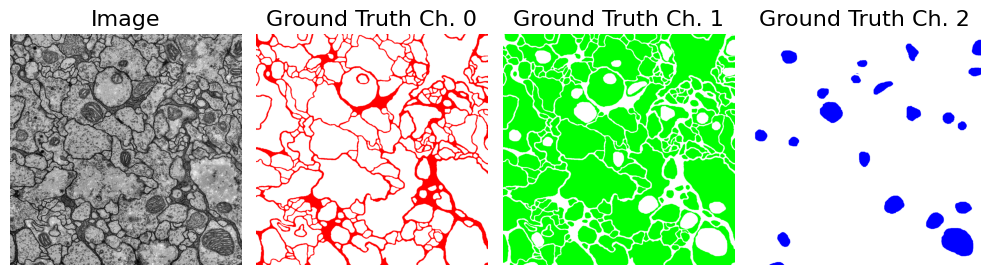

In [9]:
import matplotlib.pyplot as plt

image, segmentation = train_dataset[0]

fig, axs = plt.subplots(1, 4, figsize=(10, 5))

axs[0].imshow(image.permute(1, 2, 0), cmap="gray")
axs[0].set_title("Image", fontsize=16)
axs[0].set_axis_off()

for i in range(segmentation.shape[0]):
    segmentation_color = torch.ones_like(segmentation)
    for j in range(segmentation.shape[0]):
        if j != i: segmentation_color[j, ...] = 1 - segmentation[i, ...]
    axs[i + 1].imshow(segmentation_color.permute(1, 2, 0))
    axs[i + 1].set_title(f"Ground Truth Ch. {i}", fontsize=16)
    axs[i + 1].set_axis_off()

plt.tight_layout()
plt.show()

## Defining and Training the U-Net

Define a class to compute Jaccard Index for multi-class predictions after taking the
channel with the maximum value ...

In [10]:
from torchmetrics.classification import MulticlassJaccardIndex

class ArgmaxJI(MulticlassJaccardIndex):
    """Compute Jaccard Index for multi-class predictions after argmax."""

    def update(self, preds, targets):
        """Update Jaccard Index using argmax of class predictions."""
        super().update(preds.argmax(dim=1), targets.argmax(dim=1))

... define and compile the U-Net ...

In [11]:
import deeplay as dl

ji_metric = ArgmaxJI(num_classes=3)

unet = dl.UNet2d(
    in_channels=1, channels=[16, 32, 64, 128], out_channels=3, skip=dl.Cat(),
)
unet_reg_template = dl.Regressor(
    model=unet, loss=torch.nn.CrossEntropyLoss(), metrics=[ji_metric],
    optimizer=dl.Adam(),
)
unet_reg = unet_reg_template.create()

print(unet_reg)

Regressor(
  (loss): CrossEntropyLoss()
  (optimizer): Adam[Adam]()
  (train_metrics): MetricCollection(
    (ArgmaxJI): ArgmaxJI(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (ArgmaxJI): ArgmaxJI(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (ArgmaxJI): ArgmaxJI(),
    prefix=test
  )
  (model): UNet2d(
    (encoder): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

... define the training and validation data loaders ...

In [12]:
train_loader = dl.DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = dl.DataLoader(val_dataset, batch_size=2)

... and training the U-Net.

In [13]:
from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger("logs", name="train_100_epochs")
trainer = dl.Trainer(max_epochs=100, accelerator="auto", logger=logger)
trainer.fit(unet_reg, train_loader, val_loader)

INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | UNet2d           | 526 K  | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
526 K     Trainable params
0         Non-trainable params
526 K     Total params
2.106     Total estimated model params size (MB)
53        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollec

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Observing Overfitting

Read the training metrics ...

In [14]:
import pandas as pd

metrics = pd.read_csv(os.path.join(logger.log_dir, "metrics.csv")).ffill()

... implement a function to plot the training metrics ...

In [15]:
def plot_training_metrics(m):
    """Plot training metrics by epoch."""
    fig, axs = plt.subplots(2, figsize=(6, 4))

    axs[0].plot(m["epoch"], m["train_loss_epoch"], label="Train Loss")
    axs[0].plot(m["epoch"], m["val_loss_epoch"], label="Validation Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(m["epoch"], m["trainArgmaxJI_epoch"], label="Train JI")
    axs[1].plot(m["epoch"], m["valArgmaxJI_epoch"], label="Validation JI")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Jaccard Index (JI)")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

... and plot the training and validation metrics.

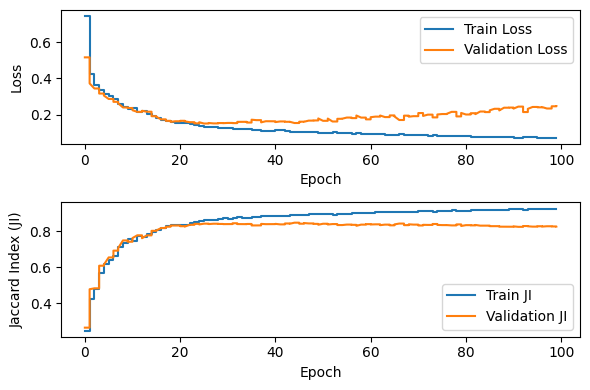

In [16]:
plot_training_metrics(metrics)

## Preventing Overfitting

Train U-Net with early stopping to prevent overfitting ...

In [17]:
from lightning.pytorch.callbacks import EarlyStopping

early_stop_unet_reg = unet_reg_template.create()

early_stop = EarlyStopping(monitor="valArgmaxJI_epoch", mode="max", patience=5)
early_stop_logger = CSVLogger("logs", name="train_until_stagnation")

early_stop_trainer = dl.Trainer(max_epochs=100, logger=early_stop_logger,
                                callbacks=[early_stop])
early_stop_trainer.fit(early_stop_unet_reg, train_loader, val_loader)

INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | UNet2d           | 526 K  | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
526 K     Trainable params
0         Non-trainable params
526 K     Total params
2.106     Total estimated model params size (MB)
53        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollec

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

... plot the training and validation metrics with early stopping ...

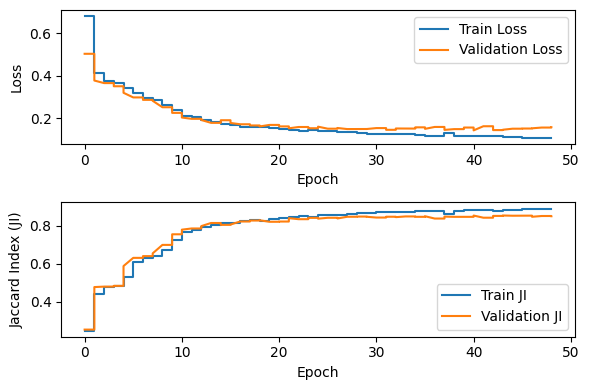

In [18]:
metrics = (pd.read_csv(os.path.join(early_stop_logger.log_dir, "metrics.csv"))
           .ffill())
plot_training_metrics(metrics)

## Evaluating the Trained U-Net

Estimate the segmentations with the U-Net ...

In [19]:
test_dataset = dt.pytorch.Dataset(pip, test_srcs)
test_loader = dl.DataLoader(test_dataset, batch_size=2, shuffle=False)
trainer.test(early_stop_unet_reg, test_loader)
pred_seg = torch.cat(trainer.predict(early_stop_unet_reg, test_loader), dim=0)

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    testArgmaxJI_epoch     │     0.822830080986023     │
│      test_loss_epoch      │    0.1759929656982422     │
└───────────────────────────┴───────────────────────────┘

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

... plot the U-Net result against the ground truth segmentation ...

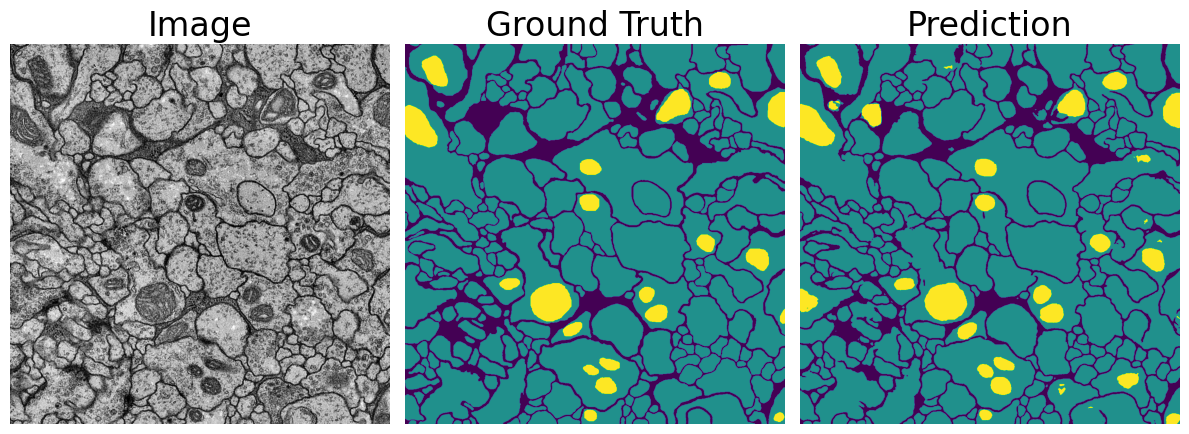

In [20]:
test_image, test_seg = test_dataset[0]

fig, axs = plt.subplots(1, 3, figsize=(12, 9))

axs[0].imshow(test_image[0], cmap="gray")
axs[0].set_title("Image", fontsize=24)
axs[0].set_axis_off()

axs[1].imshow(test_seg.argmax(dim=0))
axs[1].set_title("Ground Truth", fontsize=24)
axs[1].set_axis_off()

axs[2].imshow(pred_seg[0].argmax(dim=0))
axs[2].set_title("Prediction", fontsize=24)
axs[2].set_axis_off()

plt.tight_layout()
plt.show()

... and calcualte the test Jaccard Index.

In [21]:
ji_metric.reset()
ji_seg = ji_metric(pred_seg[0].unsqueeze(0), test_seg.unsqueeze(0))

print(ji_seg)

tensor(0.8147)
